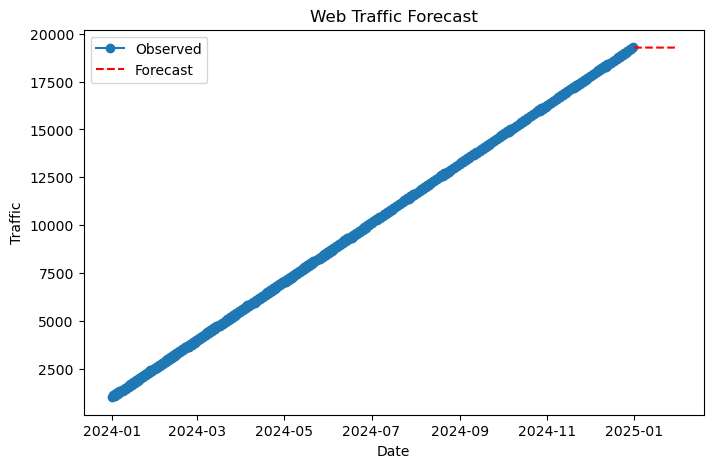

In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import tkinter as tk
from tkinter import filedialog, messagebox
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

def forecast_web_traffic(data, forecast_period=30):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    data = data.asfreq('D').ffill()  
    
    model = ExponentialSmoothing(
        data['Traffic'], seasonal='add', seasonal_periods=7  
    ).fit()
    
    forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), 
                                   periods=forecast_period, freq='D')
    forecast = model.forecast(forecast_period)
    
    return pd.DataFrame({'Date': forecast_index, 'Traffic': forecast.values})

class TrafficForecastApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Web Traffic Forecasting")

        # UI components
        self.label = tk.Label(root, text="Web Traffic Forecasting", font=("Arial", 16))
        self.label.pack(pady=10)

        self.load_button = tk.Button(root, text="Load Traffic Data", command=self.load_data)
        self.load_button.pack(pady=5)

        self.forecast_button = tk.Button(root, text="Forecast Traffic", command=self.forecast_data, state="disabled")
        self.forecast_button.pack(pady=5)

        self.plot_area = tk.Frame(root)
        self.plot_area.pack(fill=tk.BOTH, expand=True)

    def load_data(self):
        # Load the dataset
        file_path = filedialog.askopenfilename(filetypes=[("CSV Files", "web_traffic_dataset.csv")])
        if not file_path:
            return

        try:
            self.data = pd.read_csv(file_path)
            if 'Date' not in self.data.columns or 'Traffic' not in self.data.columns:
                raise ValueError("CSV must contain 'Date' and 'Traffic' columns.")
            self.forecast_button.config(state="normal")
            messagebox.showinfo("Success", "Data loaded successfully!")
        except Exception as e:
            messagebox.showerror("Error", str(e))

    def forecast_data(self):
        try:
            forecast_df = forecast_web_traffic(self.data)
            self.plot_forecast(forecast_df)
        except Exception as e:
            messagebox.showerror("Error", str(e))

    def plot_forecast(self, forecast_df):
        for widget in self.plot_area.winfo_children():
            widget.destroy()

        # Create and plot the forecast
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(self.data.index, self.data['Traffic'], label="Observed", marker='o')
        ax.plot(forecast_df['Date'], forecast_df['Traffic'], label="Forecast", linestyle='--', color='red')
        ax.set_title("Web Traffic Forecast")
        ax.set_xlabel("Date")
        ax.set_ylabel("Traffic")
        ax.legend()

        # Embed the plot in the Tkinter window
        canvas = FigureCanvasTkAgg(fig, master=self.plot_area)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

root = tk.Tk()
app = TrafficForecastApp(root)
root.mainloop()
